### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import random
import pandas as pd
import os
import sys

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# Covid epidemic simulator

In [5]:
from codit.disease import Covid
from codit.outbreak import Outbreak
from codit.population.networks.city import CityPopulation
from codit.population.covid import PersonCovid
import codit.society as society
import codit.config

/home/paul/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Baseline config of the simulation

In [6]:
codit.config.print_baseline_config()

CROSS_IMMUNITY {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: 1.0, <ImmuneResponse.B_1_1_7_INFECTION: 2>: 1.0, <ImmuneResponse.B_1_617_2_INFECTION: 4>: 1.0}, <ImmuneResponse.B_1_1_7_INFECTION: 2>: {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: 1.0, <ImmuneResponse.B_1_1_7_INFECTION: 2>: 1.0, <ImmuneResponse.B_1_617_2_INFECTION: 4>: 1.0}, <ImmuneResponse.B_1_617_2_INFECTION: 4>: {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: 1.0, <ImmuneResponse.B_1_1_7_INFECTION: 2>: 1.0, <ImmuneResponse.B_1_617_2_INFECTION: 4>: 1.0}}
DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DEFAULT_COVID ImmuneResponse.SARS_CoV_2_INFECTION
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: 0.025, <ImmuneResponse.B_1_1_7_INFECTION: 2>: 0.039, <ImmuneResponse.B_1_617_2_INFECTION: 4>: 0.

We are going to work with a small town of a few thousand people.

In [7]:
pop = CityPopulation(560000, society.Society())

2021-05-16 18:07:05,188 INFO:Building a set of 224000 households from which to build a population
2021-05-16 18:07:57,393 INFO:216566 households of mean size 2.59
2021-05-16 18:08:00,204 INFO:100120 buildings of mean size 5.59
2021-05-16 18:08:21,407 INFO:1462 classrooms of mean size 28.63
2021-05-16 18:08:21,640 INFO:76 care_homes of mean size 105.41
2021-05-16 18:08:22,224 INFO:66662 workplaces of mean size 5.60
2021-05-16 18:08:24,646 INFO:0% of workplaces closed by lockdown, leaving 55663 open, of average Income Decile 5.08 (and st dev 3.14).
2021-05-16 18:08:24,812 INFO:0% of classrooms closed by lockdown, leaving 1201 open, of average Income Decile 4.78 (and st dev 3.08).
2021-05-16 18:08:24,832 INFO:Adding 273506 permanent contact groups
2021-05-16 18:08:24,917 INFO:Adding 28000 ephemeral contact pairs
2021-05-16 18:08:25,512 INFO:Adding 168598 contacts each within one of the 100120 buildings (contact density of 0.75)


Randomly, we put them into fixed and overlapping social groupings, where each person has a small network.

In [8]:
nets = [len(p.contacts) for p in pop.people]

In [9]:
np.mean(nets)

12.464521428571429

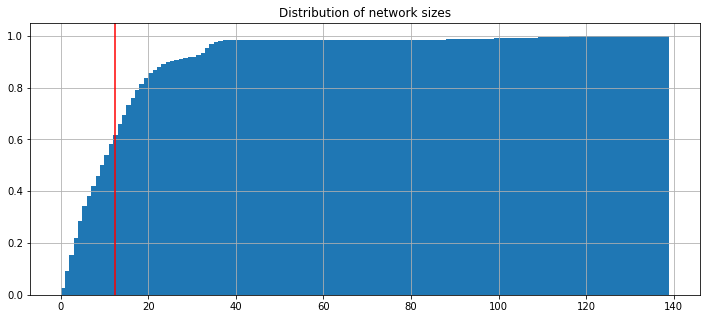

In [10]:
plt.hist(nets, cumulative=True, density=True, bins=2000)
plt.title('Distribution of network sizes')
plt.axvline(np.mean(nets), color='r')
plt.grid()

### Finally ready to simulate:

We will place the population that we have created, into various settings and societies in the upcoming simulations

In [11]:
POP_SIZE = len(pop.people)
PREVALENCE = 1/560 * 4
SCALE_SETTINGS = dict(n_days = 201, pop_size = POP_SIZE, seed_size = int(POP_SIZE*PREVALENCE), population=pop)
SCALE_SETTINGS

{'n_days': 201,
 'pop_size': 560000,
 'seed_size': 4000,
 'population': <codit.population.networks.city.CityPopulation at 0x7f63f970ad30>}

Our baseline simulation is of a runaway infection.

We start with 400 people infected in a population of 56,000.

We begin by studying a society where people don't know whether or how to self-isolate:

In [12]:
s_basic = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0))
o_basic = Outbreak(s_basic, Covid(), **SCALE_SETTINGS).simulate()

2021-05-16 18:08:49,844 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0052
2021-05-16 18:14:41,123 INFO:Day 51, prop infected is 0.44, prop infectious is 0.0851
2021-05-16 18:18:22,961 INFO:Day 101, prop infected is 0.57, prop infectious is 0.0026
2021-05-16 18:19:41,874 INFO:Day 151, prop infected is 0.57, prop infectious is 0.0000
2021-05-16 18:20:59,177 INFO:Day 201, prop infected is 0.57, prop infectious is 0.0000


2021-05-16 18:21:01,182 INFO: Realized R0 of early infections is 1.51
2021-05-16 18:21:01,183 INFO: 57.5 percent of the population was infected during the epidemic


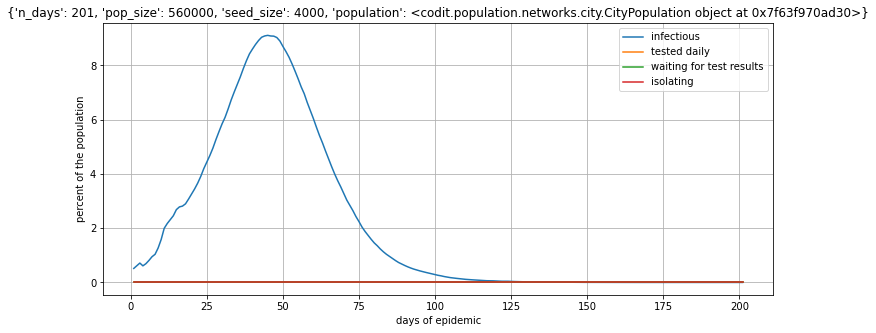

In [13]:
o_basic.plot(title=str(SCALE_SETTINGS))

Lets put that on a log scale:

2021-05-16 18:21:05,431 INFO: Realized R0 of early infections is 1.51
2021-05-16 18:21:05,432 INFO: 57.5 percent of the population was infected during the epidemic


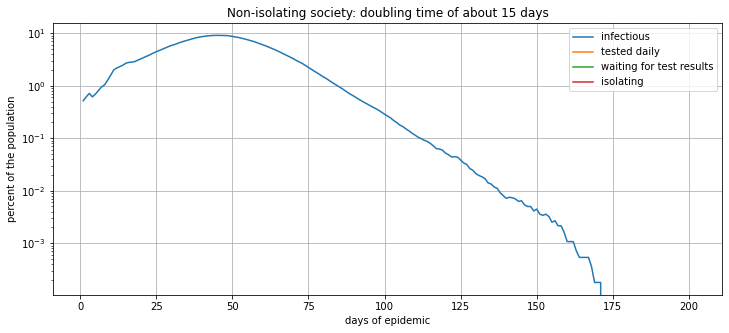

In [14]:
o_basic.plot(logy=True, title='Non-isolating society: doubling time of about 15 days')

Next, suppose that people know to isolate if they show symptoms, and 75% do so - this is similar to what is going on in the UK now:

In [15]:
s_isolate = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0.75))
o_isolate = Outbreak(s_isolate, Covid(), **SCALE_SETTINGS).simulate()

2021-05-16 18:21:18,234 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-05-16 18:23:55,411 INFO:Day 51, prop infected is 0.13, prop infectious is 0.0203
2021-05-16 18:26:46,268 INFO:Day 101, prop infected is 0.24, prop infectious is 0.0109
2021-05-16 18:28:37,902 INFO:Day 151, prop infected is 0.27, prop infectious is 0.0026
2021-05-16 18:30:04,869 INFO:Day 201, prop infected is 0.28, prop infectious is 0.0004


2021-05-16 18:30:05,708 INFO: Realized R0 of early infections is 1.15
2021-05-16 18:30:05,709 INFO: 28.1 percent of the population was infected during the epidemic


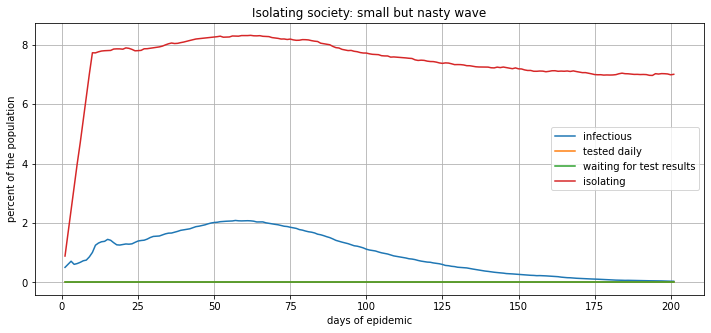

In [16]:
o_isolate.plot(title='Isolating society: small but nasty wave')

So, now we can add testing:
 * initially, here, lets suppose that positive test results are just ignored, while -ve results let people out of isolation:

In [17]:
s_testignored = society.TestingSociety(config=dict(PROB_ISOLATE_IF_TESTPOS=0))
o_testignored = Outbreak(s_testignored, Covid(), **SCALE_SETTINGS).simulate()

2021-05-16 18:30:19,035 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-05-16 18:33:32,080 INFO:Day 51, prop infected is 0.15, prop infectious is 0.0276
2021-05-16 18:37:07,647 INFO:Day 101, prop infected is 0.30, prop infectious is 0.0119
2021-05-16 18:39:03,929 INFO:Day 151, prop infected is 0.33, prop infectious is 0.0014
2021-05-16 18:40:34,224 INFO:Day 201, prop infected is 0.33, prop infectious is 0.0001


2021-05-16 18:40:35,340 INFO: Realized R0 of early infections is 1.21
2021-05-16 18:40:35,341 INFO: 32.9 percent of the population was infected during the epidemic


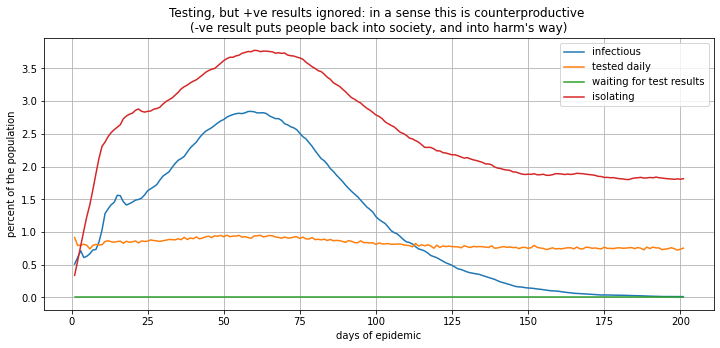

In [18]:
o_testignored.plot(title="Testing, but +ve results ignored: in a sense this is counterproductive \n"
                         "(-ve result puts people back into society, and into harm's way)")

 * Now suppose that people respond to test results, some of the time:

In [19]:
o_test = Outbreak(society.TestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-05-16 18:40:51,808 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-05-16 18:43:55,340 INFO:Day 51, prop infected is 0.14, prop infectious is 0.0243
2021-05-16 18:47:17,501 INFO:Day 101, prop infected is 0.28, prop infectious is 0.0113
2021-05-16 18:49:13,131 INFO:Day 151, prop infected is 0.30, prop infectious is 0.0013
2021-05-16 18:50:42,687 INFO:Day 201, prop infected is 0.30, prop infectious is 0.0001


2021-05-16 18:50:43,545 INFO: Realized R0 of early infections is 1.21
2021-05-16 18:50:43,546 INFO: 30.4 percent of the population was infected during the epidemic


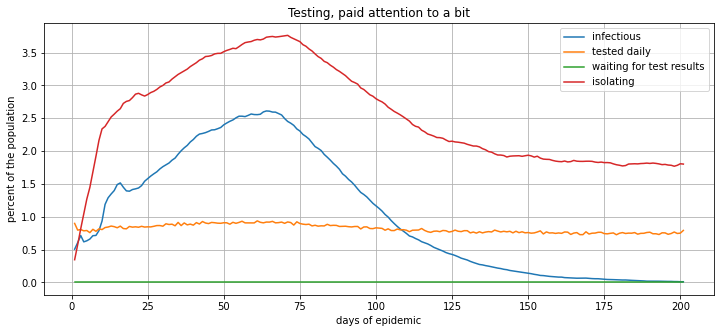

In [20]:
o_test.plot(title="Testing, paid attention to a bit")

We add contact-tracing and isolation:

In [21]:
o_test_trace = Outbreak(society.TestingTracingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-05-16 18:51:00,314 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0052
2021-05-16 18:53:15,174 INFO:Day 51, prop infected is 0.06, prop infectious is 0.0055
2021-05-16 18:55:09,061 INFO:Day 101, prop infected is 0.09, prop infectious is 0.0024
2021-05-16 18:56:52,373 INFO:Day 151, prop infected is 0.09, prop infectious is 0.0008
2021-05-16 18:58:22,869 INFO:Day 201, prop infected is 0.10, prop infectious is 0.0003


2021-05-16 18:58:23,188 INFO: Realized R0 of early infections is 1.00
2021-05-16 18:58:23,189 INFO: 9.7 percent of the population was infected during the epidemic


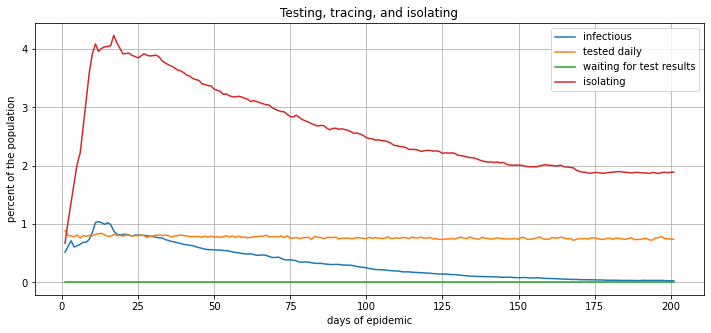

In [22]:
o_test_trace.plot(title='Testing, tracing, and isolating', secondary_y=['prop_infected'])

UK society, however, is characterized by testing bottlenecks:

In [23]:
import codit.society.alternatives as alternatives
o_UK = Outbreak(alternatives.UKSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-05-16 18:58:39,645 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-05-16 19:00:57,666 INFO:Day 51, prop infected is 0.07, prop infectious is 0.0070
2021-05-16 19:02:59,695 INFO:Day 101, prop infected is 0.11, prop infectious is 0.0043
2021-05-16 19:04:51,491 INFO:Day 151, prop infected is 0.13, prop infectious is 0.0020
2021-05-16 19:06:28,116 INFO:Day 201, prop infected is 0.13, prop infectious is 0.0008


2021-05-16 19:06:28,580 INFO: Realized R0 of early infections is 1.01
2021-05-16 19:06:28,581 INFO: 13.3 percent of the population was infected during the epidemic


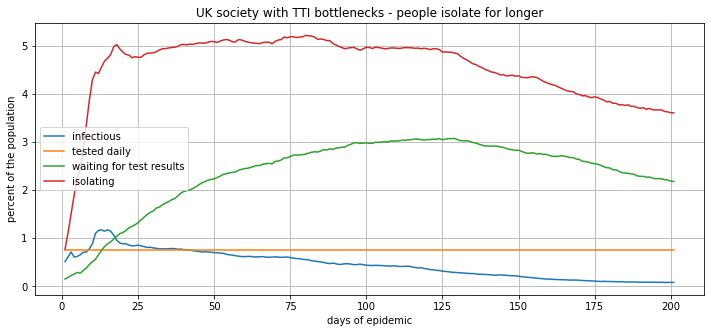

In [24]:
o_UK.plot(title='UK society with TTI bottlenecks - people isolate for longer')

In [25]:
o_contact_test = Outbreak(society.ContactTestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-05-16 19:06:46,494 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0052
2021-05-16 19:09:41,155 INFO:Day 51, prop infected is 0.10, prop infectious is 0.0153
2021-05-16 19:12:50,788 INFO:Day 101, prop infected is 0.19, prop infectious is 0.0089
2021-05-16 19:15:04,208 INFO:Day 151, prop infected is 0.22, prop infectious is 0.0026
2021-05-16 19:16:46,515 INFO:Day 201, prop infected is 0.22, prop infectious is 0.0003


2021-05-16 19:16:47,180 INFO: Realized R0 of early infections is 1.11
2021-05-16 19:16:47,181 INFO: 22.4 percent of the population was infected during the epidemic


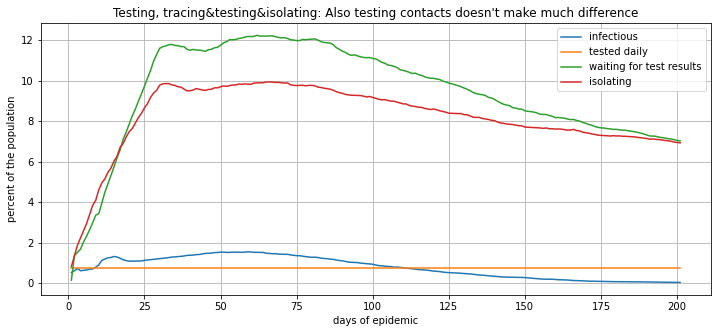

In [26]:
o_contact_test.plot(title="Testing, tracing&testing&isolating: "
                    "Also testing contacts doesn't make much difference", 
                    secondary_y=['prop_infected'])

In [29]:
infector_nets = [len(p.infectors) for p in pop.people]

In [30]:
infected_nets = [len(p.contacts) for p in pop.people if p.infectors]

In [35]:
def most_connected_infector(guy):
    return max([len(i.contacts) for i in guy.chain() if i is not guy]) 

max_contacts_chain = [most_connected_infector(person)
                      for person in pop.people 
                      if person.infectors]

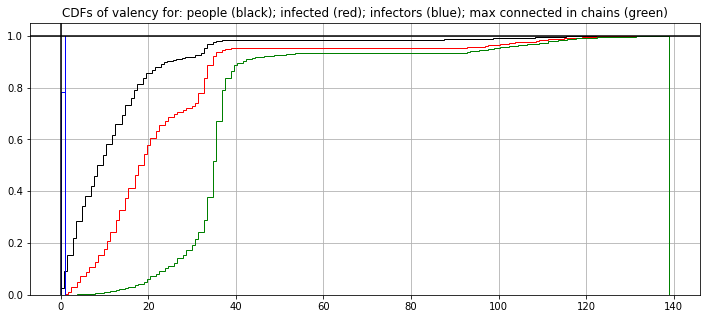

In [36]:
opts = dict(cumulative=True, bins=200, density=True, histtype='step')

plt.hist(nets, color='k', **opts)
plt.hist(infected_nets, color='r', **opts)
plt.hist(infector_nets, color='b', **opts)
plt.hist(max_contacts_chain, color='g', **opts)

plt.title("CDFs of valency for: people (black); infected (red); infectors (blue); max connected in chains (green)")
plt.axhline(1, color='k'); plt.axvline(0, color='k')
plt.grid()